# Evaluate sampling representation of the ship track
- Uses data extracted from ERA-5 along the ship track
- Compare actual data to ERA-5 along ship track to ERA-5 over the whole region, at at times of ship obs to all hours

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from orcestra_read_data import *
from thermo_functions import *

In [2]:
#Set start and end times and box
lat1 = 4.5
lat2 = 17
lon1 = -60
lon2 = -22

start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T22:00:00')

# DSHIP data

In [3]:
#Open ship data
#CID: QmSSrT1UdtocfQS5yWSHFEJwJjqcNXjq2F1QfvNgLuEqSN
DSHIP= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
Data variables: (12/39)
    PM1               (time) float64 472kB ...
    PM10              (time) float64 472kB ...
    PM2p5             (time) float64 472kB ...
    lwr               (time) float64 472kB ...
    p_air             (time) float64 472kB ...
    rh_board          (time) float64 472kB ...
    ...                ...
    wdir              (time) float64 472kB ...
    wdir_rel          (time) float64 472kB ...
    wspd              (time) float64 472kB ...
    wspd_kn           (time) float64 472kB ...
    wspd_rel          (time) float64 472kB ...
    wspd_rel_kn       (time) float64 472kB ...
Attributes:
    creator_email:  hans.segura@mpimet.mpg.de
    creator_name:   Hans Segura
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    source:         DVS DShip
    title:          Ship information database (DVS DShip) of METEOR cruise M203

In [4]:
#Interpolate DSHIP data to hourly resolution
#could use 30 minute for IMERG, but MIMIC-TPW and ERA-5 are only hourly

ship_time_interp = pd.date_range(start_time, end_time, freq='h')
ship_lat_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lat)
ship_lon_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lon)

# Radiosonde data

In [5]:
#root_radio = 'https://ipfs.io/ipfs/QmSUUUPcGcpwdJJCVDGPGYksLsqkWbfh6d6xFcTk2Qu7Zf'
#CID: QmbZQh6TcKVaWLj2x5UxqJ2nWcY3He1qwpsVQjCcUip7wq
root_radio = 'ipns://latest.orcestra-campaign.org/products/Radiosondes'
dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")

snd_asc = read_soundings(platform='RV_Meteor', ascent=0) #Read ascending soundings

# Mask soundings that don't reach 100 hPa
snd_asc, min_pres = mask_soundings(snd_asc, p_threshold=100)

times_asc = snd_asc['times']
hght = snd_asc['hght']

Define functions

In [6]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]

def vert_integral(tmpk, mr, p, hght):
    sh = mixr2sh(mr)
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * tmpk * (1. + mr*eps_r)/(1.+mr) )
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(sh*rho, axis=1)*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


Calculate column-integrated water vapor

In [7]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [8]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght) # mm or kg/m2

In [9]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)

finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]


# Precipitation data - SEA-POL

In [10]:
rain = xr.open_dataset('../ProcessedData/SEA-POL_4b_rainrate_2D_spatial_means_masked.nc')
rain

<xarray.Dataset> Size: 222kB
Dimensions:       (time: 4615)
Coordinates:
  * time          (time) datetime64[ns] 37kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain12_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain12_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

In [11]:
#Find indices for start and end times
index_start_seapol = np.where(pd.to_datetime(rain.time) == start_time)[0]
# if the start time is not in the data, use the first time
if len(index_start_seapol) == 0:
    index_start_seapol = np.where(pd.to_datetime(rain.time) > start_time)[0]
    index_start_seapol = int(index_start_seapol[0])
else:
    index_start_seapol = int(index_start_seapol[0])

index_end_seapol = np.where(pd.to_datetime(rain.time) == end_time)[0]
# if the end time is not in the data, use the last time
if len(index_end_seapol) == 0:
    index_end_seapol = np.where(pd.to_datetime(rain.time) < end_time)[0]
    index_end_seapol = int(index_end_seapol[-1])
else:
    index_end_seapol = int(index_end_seapol[0])

# Smooth with an hourly running mean, restrict to the time period of interest
precip_seapol = rain.rain12_mean[index_start_seapol:index_end_seapol+1].rolling(time=6, center=True).mean(skipna=True) # 60 minute running mean
precip_seapol



<xarray.DataArray 'rain12_mean' (time: 4615)> Size: 18kB
array([       nan,        nan,        nan, ..., 0.00050879,        nan,
              nan], shape=(4615,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 37kB 2024-08-16T08:10:00 ... 2024-09-23T16...

In [12]:
# Restrict to After Praia
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
#indexAP = np.abs(pd.to_datetime(rain.time) - APtime).argmin()
indexAP = 0 # Use all time, don't restrict to After Praia

# ERA-5 REANALYSIS DATA

The below code blocks show how to derive the alongtrack ERA-5 data. They don't need to be run to make the plot if the processed data is available.

In [13]:
##Open ERA-5 Data
#era5 = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_hrly_OLR_Prec_PW_20240809.nc')

Extract ERA5 data along ship track

In [14]:
#PW_alongtrack_era5 = np.full(len(ship_lat_interp),np.nan)
#prec_alongtrack_era5 = np.full(len(ship_lat_interp),np.nan)
#
#for itime in range(0,len(ship_lat_interp)):
#    PW_alongtrack_era5[itime] = era5.tcwv.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')
#    prec_alongtrack_era5[itime] = era5.mtpr.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], valid_time=ship_time_interp[itime],method='nearest')

Extract ERA-5 data along ship track but at all times (not just time that ship was there)

In [15]:
#for itime in range(0,len(ship_lat_interp)):
#    PW_track_era5_slice = era5.tcwv.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], method='nearest')
#    PW_track_era5_slice = PW_track_era5_slice.sel(valid_time=slice(start_time,end_time))
#
#    prec_track_era5_slice = era5.mtpr.sel(latitude=ship_lat_interp[itime],longitude=ship_lon_interp[itime], method='nearest')
#    prec_track_era5_slice = prec_track_era5_slice.sel(valid_time=slice(start_time,end_time))
#
#    if itime==0:
#        PW_track_era5 = PW_track_era5_slice
#        prec_track_era5 = prec_track_era5_slice
#    else:
#        PW_track_era5 = xr.concat([PW_track_era5,PW_track_era5_slice],dim='valid_time')
#        prec_track_era5 = xr.concat([prec_track_era5,prec_track_era5_slice],dim='valid_time')

Extract ERA-5 data within box of interest

In [16]:
#Collect ERA-5 data at all times throughout ship track and all locations within box of interest
#PW_box_era5 = era5.tcwv.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2), valid_time=slice(start_time,end_time))
#prec_box_era5 = era5.mtpr.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2), valid_time=slice(start_time,end_time))

Read in already sampled ERA-5 data

In [17]:
era5 = xr.open_dataset('../ProcessedData/IWVprecip_alongtrack_sampling.nc')
PW_alongtrack_era5 = era5.PW_alongtrack_era5.values
PW_track_era5 = era5.PW_track_era5
PW_box_era5 = era5.PW_box_era5
prec_alongtrack_era5 = era5.precip_alongtrack_era5.values
prec_track_era5 = era5.precip_track_era5
prec_box_era5 = era5.precip_box_era5

# Plot

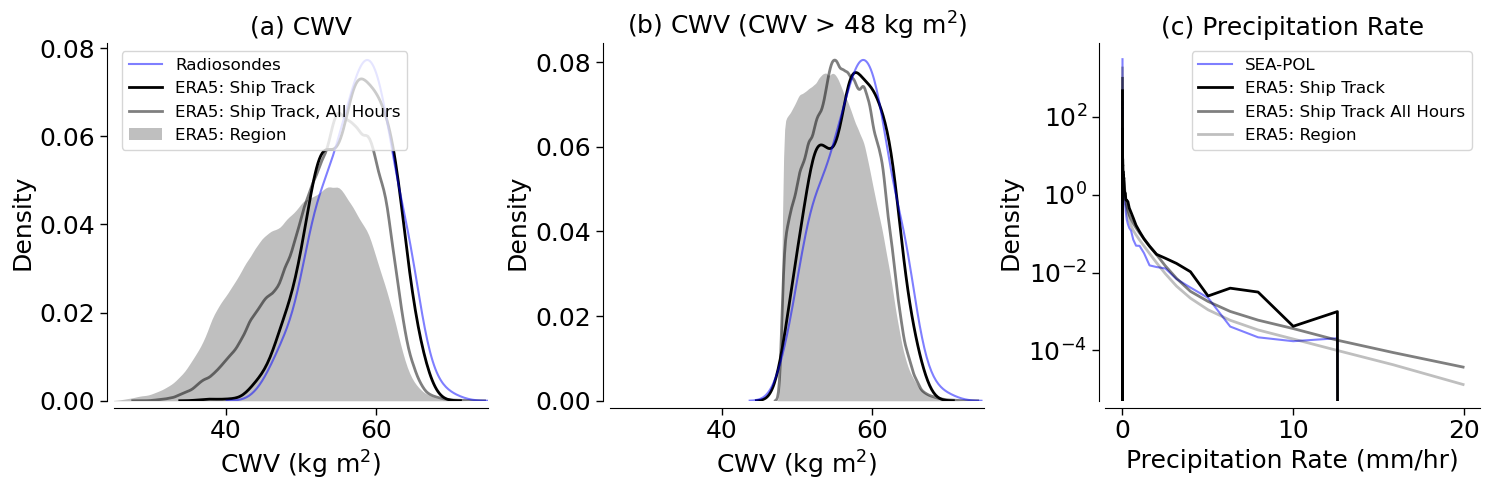

In [18]:
# Create probability density plots

fig, axs = plt.subplots(1,3,figsize=(15,5))

sns.kdeplot(cwv_finite,ax=axs[0],label='Radiosondes',fill=False,color='blue',zorder=5,alpha=0.5)
sns.kdeplot(PW_alongtrack_era5,ax=axs[0],label='ERA5: Ship Track',fill=False, color='black',zorder=3,linewidth=2)
sns.kdeplot(PW_track_era5,ax=axs[0],label='ERA5: Ship Track, All Hours',fill=False, color='black',alpha=0.5,zorder=3,linewidth=2)
sns.kdeplot(PW_box_era5.values.flatten(),ax=axs[0],label='ERA5: Region',fill=True,color='black',alpha=0.25,linewidth=0,zorder=1)

axs[0].set_title('(a) CWV',fontsize=18)
axs[0].set_xlabel('CWV (kg m$^2$)',fontsize=18)
axs[0].set_ylabel('Density',fontsize=18)
axs[0].legend(loc='upper left',fontsize=12)
axs[0].set_xlim(25,75)
axs[0].tick_params(labelsize=18)

sns.kdeplot(cwv_finite[cwv_finite>48],ax=axs[1],label='Radiosondes',fill=False,color='blue',zorder=5,alpha=0.5)
sns.kdeplot(PW_alongtrack_era5[PW_alongtrack_era5>48],ax=axs[1],label='ERA5: Ship Track',fill=False, color='black',zorder=3,linewidth=2)
sns.kdeplot(PW_track_era5[PW_track_era5>48],ax=axs[1],label='ERA5: Ship Track, All Hours',fill=False, color='black',alpha=0.5,zorder=3,linewidth=2)
sns.kdeplot(PW_box_era5.values[PW_box_era5.values>48],ax=axs[1],label='ERA5: Region',fill=True,color='black',alpha=0.25,linewidth=0,zorder=1)

axs[1].set_title('(b) CWV (CWV > 48 kg m$^2$)',fontsize=18)
axs[1].set_xlabel('CWV (kg m$^2$)',fontsize=18)
axs[1].set_ylabel('Density',fontsize=18)
#axs[1].legend(loc='upper left')
axs[1].set_xlim(25,75)
axs[1].tick_params(labelsize=18)

pbins = np.concatenate(([0],np.power(10,np.arange(-4,1.5,0.1))))

#phist1, bin_edges1 = np.histogram(precip, bins=pbins, density=True) #disdrometer
phist2, bin_edges2 = np.histogram(prec_alongtrack_era5*3600, bins=pbins, density=True)
phist3, bin_edges3 = np.histogram(prec_track_era5*3600, bins=pbins,density=True)
phist4, bin_edges4 = np.histogram(prec_box_era5.values.flatten()*3600, bins=pbins,density=True)
phist5, bin_edges5 = np.histogram(precip_seapol[indexAP:-1], bins=pbins, density=True)

#axs[2].plot(bin_edges1[:-1], phist1, color='blue', label='Disdrometer',alpha=0.5)
axs[2].plot(bin_edges5[:-1], phist5, color='blue', label='SEA-POL',alpha=0.5)
axs[2].plot(bin_edges2[:-1], phist2, color='black', label='ERA5: Ship Track',linewidth=2)
axs[2].plot(bin_edges3[:-1], phist3, color='black', alpha=0.5, label='ERA5: Ship Track All Hours',linewidth=2)
axs[2].plot(bin_edges4[:-1], phist4, color='black', alpha=0.25, label='ERA5: Region',linewidth=2)

axs[2].set_title('(c) Precipitation Rate',fontsize=18)
axs[2].set_xlabel('Precipitation Rate (mm/hr)',fontsize=18)
axs[2].set_ylabel('Density',fontsize=18)
axs[2].legend(loc='upper right',fontsize=12)
#axs[2].set_xscale('log')
axs[2].set_yscale('log')
#axs[2].set_xlim(0,20)
#axs[2].set_ylim(0.0001,10)
axs[2].tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

fig.savefig('../Plots/Fig_sampling.png', bbox_inches='tight', dpi=300)